# Navigating Turbulent Odor Plumes Using Reinforcement Learning

This notebook uses the Q-learning algorithm of Reinforcement Learning (RL) to train virtual agents to navigate a 2D turbulent odor plume. Turbulent odor plumes are spatiotemporally complex: odor signals arrive in random, unpredictable bursts, and odor concentration does follow continuous gradients, making plume navigation a difficult task. Suprisingly, there has been no published work on applying RL algorithms to turbulent odor plume navigation. 

## Q-learning algorithm
Q-learning updates a state-action value function, $Q(a, s)$, which quantifies the value of taking action $a$ when in state $s$. This function is updated in time using the Q-learning algorithm. At each timestep, the navigator takes an action $A$ to go from state $S$ to state $S'$, using whatever policy (greedy, $\epsilon$-greedy, etc.), where it receives a reward $R$. Then $Q(A, S)$ is updated using a *greedy* update rule (hence *off-policy*):

$\begin{align}
 Q(A, S) \leftarrow Q(A, S) + \alpha[R + \gamma \max_a Q(a, S')  - Q(A, S)]
\end{align}$

Here, $\alpha < 1$ and $\gamma < 1$ are update step-size and learning rate -- both hyperparameters in the simulation.

### State space: $\{s\}$

Following results found recently for navigation of odor plumes by fruit flies, we assume that navigators rely on the frequency of odor hits. An odor hit is the time at which the signal surpassses a given threshold. Running average of hit frequency, $W_freq$, is found by convolving the binary time series of odor hit times $w(t)$ with an exponential kernel ($\tau = 2$ seconds):

$W_{freq} = \int^t_{-\infty} e^{-(t-t')/\tau} w(t')dt'$

We discretize the state space into low and high frequency,

$S_1$: $W_{freq} < \text{thresh}$

$S_2$: $W_{freq} >= \text{thresh}$

where $thresh$ is to be chosen

### Action space: $\{a\}$
The navigators move on a grid, and we assume that there are 4 actions:

$A_1$: turn upwind (i.e. left)
$A_2$: walk straight
$A_3$: turn randomly in one of the 4 directions
$A_4$: turn toward the plume centerline

The last action $A_4$ means that, in the plume cone, flies in the top half will turn downward, and flies in the bottom half will turn upward. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('src')
from utils import gen_plot
#from models import *

In [ ]:
"""
RL models

Created by Nirag Kadakia at 21:37 08-23-2020
This work is licensed under the 
Creative Commons Attribution-NonCommercial-ShareAlike 4.0 
International License. 
To view a copy of this license, visit 
http://creativecommons.org/licenses/by-nc-sa/4.0/.
"""

import sys
import numpy as np
import cv2

class odor_series_RL(object):
    
    """
    Reinforced learning simulation where states are defined by the 
    odor history in the recent past.
    """

    def __init__(self):
        """
        Define video file, video, and RL parameters.
        """

        self.vid_file = r'data/intermittent_smoke.avi'
        self.beg_frm = 500
        self.max_frms = 5000
        self.xy_step = 5
        self.num_steps = 3000
        self.x0_min = 1200
        self.x0_max = 1400
        self.max_x = 1500
        self.max_y = 840
        self.y_center = 450
        self.y0_spread = 100

        # Number of parallel agents
        self.num_walkers = 100
        self.alpha = 0.9
        self.gamma = 0.9

        # epsilon-greedy action selection
        self.epsilon = 0.05

    def def_states(self, odor_threshold=100, odor_vec_len=500, 
                   freq_bins=[-0.01, 2, 100], tau=2):
        """
        States are delineated by odor frequency, which is defined
        by an exponential timescale
        """

        self.odor_threshold = odor_threshold
        self.odor_vec_len = odor_vec_len
        self.freq_bins = freq_bins
        self.tau = tau
        self._num_states = len(self.freq_bins) - 1

    def def_actions(self):
        """
        Actions defined by motion `v' in run script
        """
        
        self._num_actions = 4

    def init_vars(self):
        """
        Initialize data structures used in simulation
        """
        
        xs = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        ys = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        vs = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        states = np.zeros((self.num_steps, self.num_walkers), dtype=int)
        Q = np.ones((self.num_steps, self._num_states, 
                     self._num_actions, self.num_walkers))

        # Binary vectory indicating if path reached source
        ends = np.zeros(self.num_walkers)

        # Length of trajectory from initial point to source in timesteps
        path_lengths = np.ones(self.num_walkers).astype(int)*self.num_steps

        # Initial x,y are random; initial motion is upwind (v = 2)
        xs[0] = np.random.randint(self.x0_min, 
                                  self.x0_max, 
                                  self.num_walkers)
        ys[0] = np.random.randint(self.y_center - self.y0_spread, 
                                  self.y_center + self.y0_spread, 
                                  self.num_walkers)
        vs[0] = np.ones(self.num_walkers)*2
    
        # Holds odor vector to define states
        odors = np.zeros((self.odor_vec_len, self.num_walkers))
        
        return xs, ys, vs, states, Q, ends, path_lengths, odors
    
    def init_vid(self):
        """
        Load video; set initial frame
        """
        
        self.cap = cv2.VideoCapture(self.vid_file)
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.beg_frm)
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.frm_num = 0
        
    def update_actions_from_Q(self, Q, states, iS):
        """
        Get optimal actions from Q function
        """

        # Q for state and action at last timestep
        last_Q = Q[iS, states[iS], :, np.arange(self.num_walkers)].T

        # Binary array of size (num_actions, num_walkers) for previous state. 
        # Equals `1' if that action is optimal (there can be degeneracies).
        opt_action_arr = 1.*(last_Q == np.amax(last_Q, axis=0))

        # From the optimal actions, choose randomly by random shifts 
        # around `1' + sorting
        opt_action_arr *= np.random.normal(1, 0.01, opt_action_arr.shape)
        actions = np.argmax(opt_action_arr, axis=0)

        # Epsilon-greedy action selection randomizes actions with prob=epsilon
        actions_to_flip = np.random.uniform(0, 1, self.num_walkers) > \
                         (1. - self.epsilon)
        random_actions = np.random.randint(0, self._num_actions, 
                                           self.num_walkers)
        actions[actions_to_flip] = random_actions[actions_to_flip]

        return actions

    def update_xys(self, xs, ys, vs, actions, iS):
        """
        Update navigator positions given selected actions
        """

        _xs = xs[iS]
        _ys = ys[iS]
        _vs = vs[iS]
        
        # Update _xs, _ys, _vs based on some algorithm
        
        xs[iS + 1] = _xs
        ys[iS + 1] = _ys
        vs[iS + 1] = _vs

        return xs, ys, vs

    def get_vid_frm(self):
        """
        Get a single frame from video
        """
        
        if self.frm_num > self.max_frms:
            self.cap = cv2.VideoCapture(self.vid_file)
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.beg_frm)
            self.frm_num = 0
        self.frm_num += 1
        ret, frm = self.cap.read()
        frm = frm[:, :, 2]
        
        return frm
    
    def update_states(self, xs, ys, states, odors, iS):
        """
        Update the odor vector and the next state based on odor signal
        """

        frm = self.get_vid_frm()
        
        # Whiff is binary; 1 if greater than odor threshold
        whfs = 1.*(frm[(ys[iS], xs[iS])] > self.odor_threshold)

        # Append new signal to odor vector (odors in recent past)
        odors = np.roll(odors, -1, axis=0)
        odors[-1] = whfs

        # Freq of odor whiffs by discounting recent odor hits (diff of odors)
        # with a 2s decaying exponential
        whf_freqs = np.sum((np.diff(odors, axis=0) > 0).T*
                          np.exp(-np.arange(odors.shape[0] - 1).T
                          /self.tau/self.fps)[::-1], axis=1)

        states[iS + 1] = np.digitize(whf_freqs, self.freq_bins, right=True) - 1

        return whfs, whf_freqs, odors, states

    def get_terminal_paths(self, xs, ys, ends, path_lengths, iS):
        """
        Determine paths that reached source.
        """
        
        _ends = (xs[iS] < 150)*(abs(ys[iS] - self.y_center) < 50)
        path_lengths[(ends == 0)*_ends] = iS
        ends[_ends] = 1

        return ends, path_lengths
          
    def update_Q(self, Q, states, actions, rewards, iS):
        """
        Update Q-function: this is the Q-learning step
        """
        
        # All Qs at this timestep are the same as last, except the current
        # (state, action) pair, which is being updated
        Q[iS + 1] = Q[iS]
        Q[iS + 1, states[iS], actions, np.arange(self.num_walkers)] = \
            Q[iS, states[iS], actions, np.arange(self.num_walkers)] + \
            self.alpha*(rewards + self.gamma*np.amax(Q[iS, states[iS + 1], 
            :, np.arange(self.num_walkers)].T, axis=0) - \
            Q[iS, states[iS], actions, np.arange(self.num_walkers)])

        return Q
    
    def update_actions_optimally(self, Q_terminal, states, temp, iS):
        """
        Determine optimal actions using Q function.
        """
        
        #TODO: parallelize
        #opt_actions = np.argmax(Q_terminal, axis=-1)
        boltzmann_p = (np.exp(Q_terminal.T/temp)/
                       np.sum(np.exp(Q_terminal/temp), axis=-1)).T
        actions = np.zeros(self.num_walkers)
        for iW in range(self.num_walkers):
            actions[iW] = np.random.choice(np.arange(self._num_actions), 
                                               p=boltzmann_p[states[iS, iW]])
        actions_to_flip = np.random.uniform(0, 1, self.num_walkers) > \
                         (1. - self.epsilon)
        random_actions = np.random.randint(0, self._num_actions, 
                                           self.num_walkers)
        actions[actions_to_flip] = random_actions[actions_to_flip]

        return actions

    def run(self, seed=0):
        """
        Do 1 run of LR to get Q-function
        """

        np.random.seed(seed)
        self.init_vid()
        xs, ys, vs, states, Q, ends, path_lengths, odors = self.init_vars()
        
        for iS in range(self.num_steps - 1):
            sys.stdout.write('\r')
            sys.stdout.write("{:.1f}%".format((100/(self.num_steps - 1)*iS)))
            sys.stdout.flush()

            # Update actions and positions based on optimal actions
            actions = self.update_actions_from_Q(Q, states, iS)
            xs, ys, vs = self.update_xys(xs, ys, vs, actions, iS)

            # Mark those that reached the source and how long to do so
            ends, path_lengths = self.get_terminal_paths(xs, ys, ends, path_lengths, iS)
            
            # Update odor vector, states, rewards, value function
            whfs, whf_freqs, odors, states = \
                self.update_states(xs, ys, states, odors, iS)
            rewards = whfs #((odors[-1] - odors[-2]) > 0)
            Q = self.update_Q(Q, states, actions, rewards, iS)
        
        # Save normalized Q values at point that trajectory reaches source 
        # (or end of video)
        Q_terminal = np.zeros((self._num_states, self._num_actions))
        for iW in range(self.num_walkers):
            Q_terminal += Q[path_lengths[iW] - 1, :, :, iW]
        
        return xs, ys, Q, Q_terminal, path_lengths
    
    def run_optimal_action(self, Q_terminal, seed=0, Boltzmann=True, temp=100):
        """
        Do 1 run using optimal actions; epsilon-greedy
        """

        np.random.seed(seed)
        self.init_vid()
        xs, ys, vs, states, _, ends, path_lengths, odors = self.init_vars()
        
        for iS in range(self.num_steps - 1):
            sys.stdout.write('\r')
            sys.stdout.write("{:.1f}%".format((100/(self.num_steps - 1)*iS)))
            sys.stdout.flush()

            # Assign optimal actions; epsilon-greedy; update states
            actions = self.update_actions_optimally(Q_terminal, states, temp, iS)
            xs, ys, vs = self.update_xys(xs, ys, vs, actions, iS)

            # Mark those that reached the source and how long to do so
            ends, path_lengths = self.get_terminal_paths(xs, ys, ends, path_lengths, iS)
            
            # Grab odor signal from current frame; cycle video if reached end
            frm = self.get_vid_frm()
            
            # Update odor vector and state
            whfs, whf_freqs, odors, states = \
                self.update_states(xs, ys, states, odors, iS)
        
        return xs, ys, path_lengths

## Define model classes

In [113]:
class centerline_upwind_downwind(odor_series_RL):
    """
    Reinforced learning simulation where navigators can i) go straight, 
    ii) go upwind, iii), turn toward plume centerline, or 
    iv) go downwind
    """

    def __init__(self):
        super().__init__()
    
    def def_actions(self):
        """
        Actions defined by motion `v' in run script
        """
        
        self._num_actions = 4
    
    def update_xys(self, xs, ys, vs, actions, iS):
        """
        Update navigator positions given selected actions
        """

        _xs = xs[iS]
        _ys = ys[iS]

        _xs[_xs > self.max_x] = self.max_x
        _ys[_ys > self.max_y] = self.max_y
        _xs[_xs < 0] = 0
        _ys[_ys < 0] = 0

        # Actions give change in velocity v: 0=right (downwind), 
        # 1=up (crosswind), 2=left (upwind), 3=down (crosswind). 
        
        # Actions: 
        #	0: go upwind (_v = 2)
        #	1: keep same direction (_v = v[iS])
        #	2: go toward centerline (_v = 1 or 3 depending on y)
        #	3: go downwind (_v = 0)
        
        _vs = np.empty(self.num_walkers)*np.nan
        _vs[actions == 0] = 2
        _vs[actions == 1] = vs[iS, actions == 1]
        _vs[actions == 2] = (ys[iS, actions == 2] > self.y_center)*3 + \
                            (ys[iS, actions == 2] <= self.y_center)*1
        _vs[actions == 3] = 0

        _xs[_vs == 0] += self.xy_step
        _ys[_vs == 1] += self.xy_step
        _xs[_vs == 2] -= self.xy_step
        _ys[_vs == 3] -= self.xy_step

        xs[iS + 1] = _xs
        ys[iS + 1] = _ys
        vs[iS + 1] = _vs

        return xs, ys, vs


class centerline_upwind_downwind_turns(odor_series_RL):
    """
    Reinforced learning simulation where navigators can i) go straight, 
    ii) turn upwind, iii) turn downwind, iv) possibly turn to centerline 
    """

    def __init__(self):
        super().__init__()
        
    def def_actions(self, centerline=True):
        """
        Actions defined by motion `v' in run script
        """
        
        if centerline == True:
            self._num_actions = 4
        else:
            self._num_actions = 3

    def update_xys(self, xs, ys, vs, actions, iS):
        """
        Update navigator positions given selected actions
        """

        _xs = xs[iS]
        _ys = ys[iS]

        _xs[_xs > self.max_x] = self.max_x
        _ys[_ys > self.max_y] = self.max_y
        _xs[_xs < 0] = 0
        _ys[_ys < 0] = 0

        # Actions give change in velocity v, 0-4; 0=right (downwind), 
        # 1=up (crosswind), 2=left (upwind), 3=down (crosswind). 
        # Actions: 
        #   0: go straight
        #   1: turn upwind (_v->2 if v = 1, 2, 3, _v->1,3 if v=0)
        #   2: turn downwind (_v->0 if v = 1, 0, 3, _v->1,3 if v=2)
        #   3: turn toward centerline 
        _vs = np.empty(self.num_walkers)*np.nan
        rnd = np.random.choice([1, 3])
        _vs[actions == 0] = vs[iS, actions == 0]
        _vs[actions == 1] = 2*(vs[iS, actions == 1] == 1) + \
                            2*(vs[iS, actions == 1] == 2) + \
                            2*(vs[iS, actions == 1] == 3) + \
                            rnd*(vs[iS, actions == 1] == 0)
        _vs[actions == 2] = 0*(vs[iS, actions == 2] == 1) + \
                            0*(vs[iS, actions == 2] == 3) + \
                            0*(vs[iS, actions == 2] == 0) + \
                            rnd*(vs[iS, actions == 2] == 2)
        _vs[actions == 3] = (ys[iS, actions == 3] > self.y_center)*3 + \
                            (ys[iS, actions == 3] <= self.y_center)*1
        
        _xs[_vs == 0] += self.xy_step
        _ys[_vs == 1] += self.xy_step
        _xs[_vs == 2] -= self.xy_step
        _ys[_vs == 3] -= self.xy_step

        xs[iS + 1] = _xs
        ys[iS + 1] = _ys
        vs[iS + 1] = _vs

        return xs, ys, vs

In [180]:
a = centerline_upwind_downwind()
a.num_walkers = 500
a.def_actions()
a.num_steps = 2000
a.def_states(freq_bins=[-1, 0.5, 3, 5, 7, 100])
xs, ys, Q, Q_terminal, path_lengths = a.run()

99.9%

In [184]:
xs, ys, path_lengths = a.run_optimal_action(Q_terminal, temp=100)

99.9%

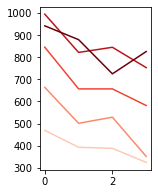

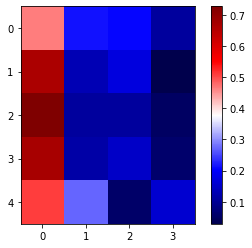

In [189]:
fig = plt.figure(figsize=(2, 3))
colors = plt.cm.Reds(np.linspace(0.2, 1.0, a._num_states))
for i in range(a._num_states):
    plt.plot(Q_terminal[i], color=colors[i])
plt.show()
temp = 100
Q_norm = (np.exp(Q_terminal.T/temp)/np.sum(np.exp(Q_terminal/temp), axis=-1)).T
plt.imshow(Q_norm, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

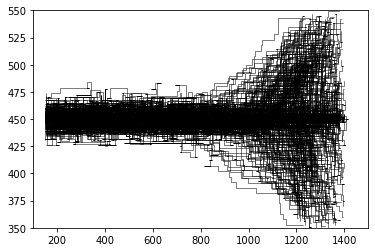

In [186]:
#colors = np.vstack((np.zeros(a.num_walkers), np.diff(xs, axis=0) < 0))
#plt.scatter(xs, ys, c = colors, s = 5, cmap=plt.cm.seismic)
for iW in range(a.num_walkers):
    plt.plot(xs[:path_lengths[iW], iW], ys[:path_lengths[iW], iW], color='k', lw=0.5)
plt.xlim(100, 1500)
plt.ylim(450 - 100, 450 + 100)
plt.show()